# Quelques statistiques sur notre base de données.

In [627]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import geopandas as gpd
import shapely as sp
from shapely.geometry import Point
from pyproj import CRS, Transformer
import matplotlib.animation as animation
from datetime import timedelta
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
import datetime
from sklearn.metrics import classification_report, accuracy_score

#Importation de tous les packages

In [2]:
data=pd.read_csv('14123463916_v1_7_Heranval_FR_LH_20180101_20240601_QC0p-1-2.csv')

In [3]:
data.count()
#On compte 4964 observations

ID             4964
QC_LEVEL       4964
INFO_SOURCE    4964
CONTACT        4964
EMAIL             0
               ... 
CREATOR_ID     4964
REVISOR_ID     4964
LINK_ORG       4959
LINK_ID        4959
DELETED        4964
Length: 100, dtype: int64

In [4]:
data['TYPE_EVENT'].value_counts()["HAIL"]
#Toutes les observations sont des observations de grele

4964

In [5]:
data['TIME_EVENT'] = pd.to_datetime(data['TIME_EVENT'], format='%Y-%m-%d %H:%M:%S')

data['Mois'] = data['TIME_EVENT'].dt.month
data['Jour'] = data['TIME_EVENT'].dt.day
data['Heure'] = data['TIME_EVENT'].dt.hour

#On extrait les informations de date pour les futurs graphiques

## Heatmap calendaire.

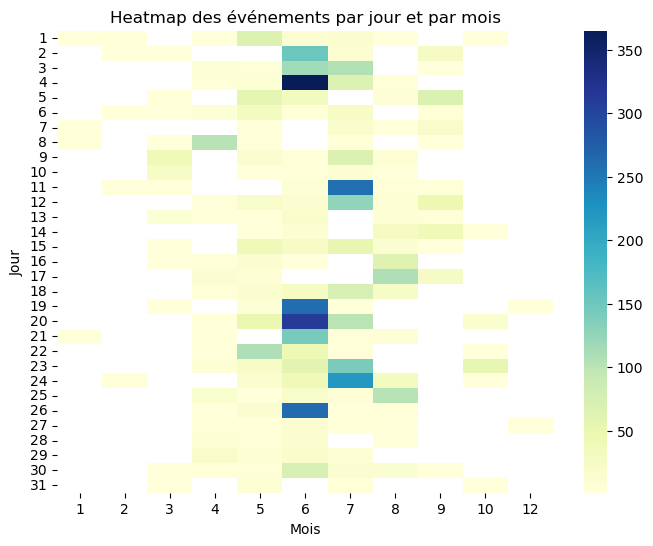

In [6]:
heatmap_data = data.pivot_table(index='Jour', columns='Mois', values='TIME_EVENT', aggfunc='count')
#On utilise une table de pivot

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)
plt.xlabel('Mois')
plt.ylabel('Jour')
plt.title('Heatmap des événements par jour et par mois')
plt.show()

## Histogramme mensuel.

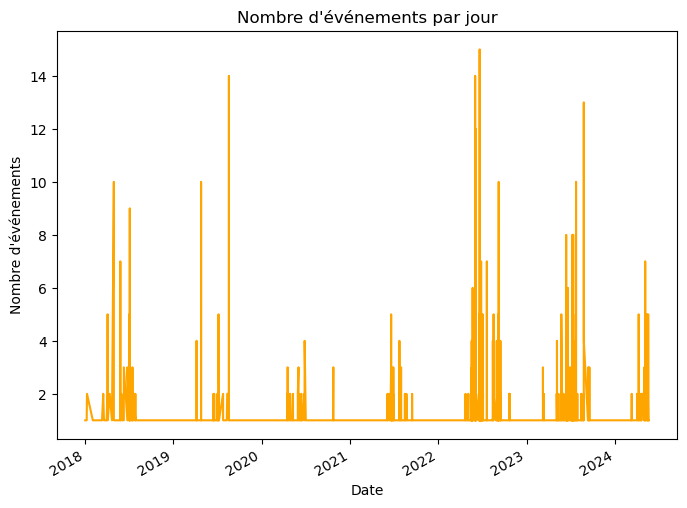

In [7]:
events_per_day = data['TIME_EVENT'].value_counts().sort_index()

events_per_day.plot(figsize=(8, 6),color='orange')
plt.xlabel('Date')
plt.ylabel('Nombre d\'événements')
plt.title('Nombre d\'événements par jour')
plt.show()

## Élaboration d'un score de fiabilité.

In [8]:
def calculate_accuracy_score_timewise(accuracy):
    if accuracy == '1M':
        return 10
    elif accuracy == '5M':
        return 8
    elif accuracy == '15M':
        return 7
    elif accuracy == '30M':
        return 6
    elif accuracy == '1H':
        return 4
    elif accuracy == '3H':
        return 2
    elif accuracy == '6H':
        return 1
    elif accuracy == '12H':
        return 0.5
    else:
        return 0
    
data['TIMEWISE_ACCURACY_SCORE'] = data['TIME_ACCURACY'].apply(calculate_accuracy_score_timewise)

#On calcule un score de precision temporelle

In [9]:
def calculate_accuracy_score_geographically(accuracy):
    if accuracy == '1KM':
        return 10
    elif accuracy == '3KM':
        return 8
    elif accuracy == '5KM':
        return 7
    elif accuracy == '10KM':
        return 5
    elif accuracy == '20KM':
        return 3
    elif accuracy == '50KM':
        return 1.5
    elif accuracy == '100KM':
        return 0.5
    else:
        return 0
    
data['PLACE_ACCURACY_SCORE'] = data['PLACE_ACCURACY'].apply(calculate_accuracy_score_geographically)

#On calcule un score de precision geographique

In [10]:
print(np.mean([data["PLACE_ACCURACY_SCORE"].mean(),data['TIMEWISE_ACCURACY_SCORE'].mean()]),
[data["PLACE_ACCURACY_SCORE"].std(),data['TIMEWISE_ACCURACY_SCORE'].std()])

#On calcule un score de fiabilite pour les observations de la table : on observe une bonne fiabilite moyenne, mais un ecart-type non negligeable

7.859538678485093 [1.6225472572738318, 1.0988111462531895]


## Heatmap géographique.

In [11]:
file_path = "/Users/samnorsa/Desktop/Stage_CREST/code2/ADMIN-EXPRESS_3-2__SHP_LAMB93_FXX_2024-07-15/ADMIN-EXPRESS/1_DONNEES_LIVRAISON_2024-07-00082/ADE_3-2_SHP_LAMB93_FXX-ED2024-07-15/DEPARTEMENT.shp"
gdf_france = gpd.read_file(file_path)

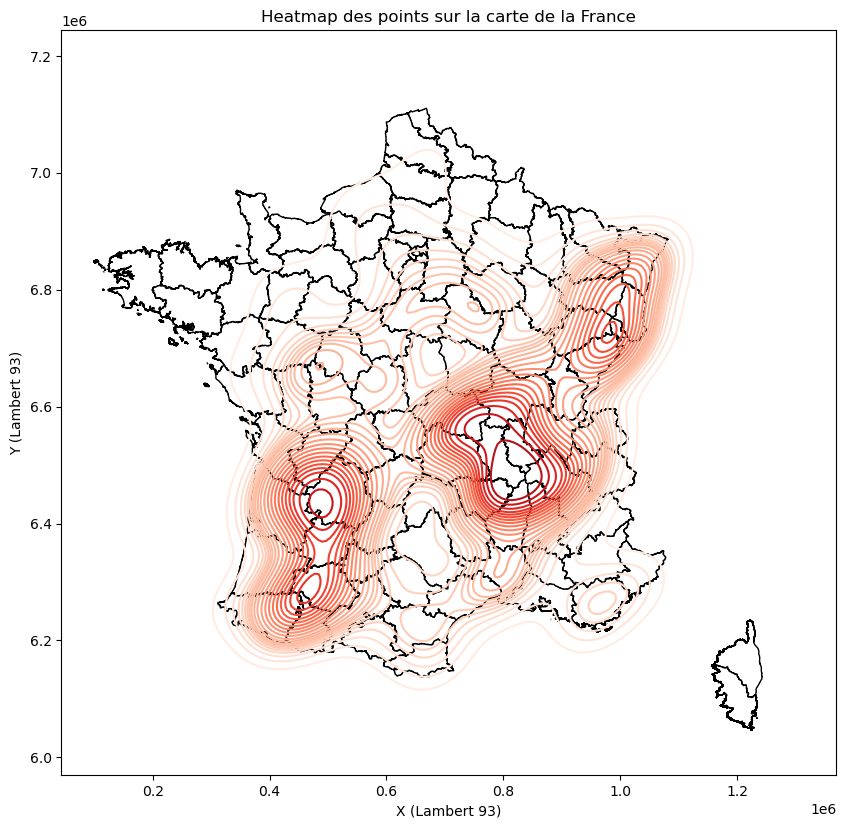

In [12]:
gdf_points = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.LONGITUDE, data.LATITUDE), crs="EPSG:4326")

gdf_points = gdf_points.to_crs(epsg=2154)

gdf_points['x'] = gdf_points.geometry.x
gdf_points['y'] = gdf_points.geometry.y

fig, ax = plt.subplots(figsize=(10, 10))
gdf_france.to_crs(epsg=2154).plot(ax=ax, color='white', edgecolor='black')

sns.kdeplot(
    data=gdf_points,
    x='x', y='y',
    cmap="Reds", fill=False, thresh=0, levels=25, ax=ax)

plt.title("Heatmap des points sur la carte de la France")
plt.xlabel("X (Lambert 93)")
plt.ylabel("Y (Lambert 93)")
plt.show()


# Apprentissage Automatique.

## Clustering.

Tentons désormais de grouper ces observations, de façon à réduire leur nombre et à pouvoir essayer d'estimer ce qu'il va se passer pour les années à venir, en terme de gravité d'évènement (diamètre des billes de grêle) et de nombre d'occurrence.

Les paramètres que nous prendrons en compte seront :
- Le diamètre des billes de grêle
- L'épaisseur de la grêle ("thickness_hail_layer")
- La position géographique
- La date
- La description faite dans "time_description"

Note à moi-même : on peut essayer d'utiliser les statistiques desciptives qu'on aura obtenues sur ces paramètres pour en tirer des informations sur la nature à se répéter souvent ou non de ces évènements, etc.

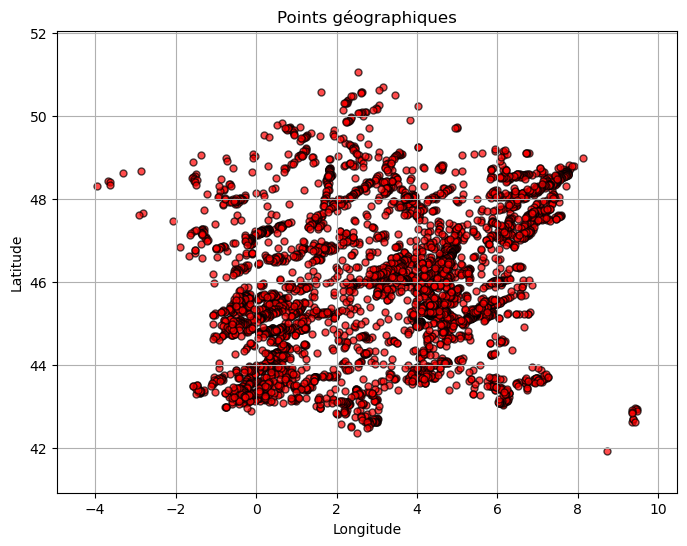

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(data['LONGITUDE'], data['LATITUDE'], color='red', s=100, alpha=0.7, edgecolor='black',marker=".")

ax.set_title('Points géographiques')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.set_xlim(data['LONGITUDE'].min() - 1, data['LONGITUDE'].max() + 1)
ax.set_ylim(data['LATITUDE'].min() - 1, data['LATITUDE'].max() + 1)

ax.grid(True)

plt.show()

Peu de clusters se dégagent : on comprend donc qu'il va mieux valoir établir soi-même ses règles de décisions que de confier ce job à K-Moyennes par exemple.

Après quelques recherches sur Google, on sait que 1° de latitude correspond à 11km et, qu'au niveau de la France, 1° de longitude correspond (environ) à 78km.
Mettons donc en place un moyen de calculer la distance entre deux évènements.

In [14]:
def distance_pythagore(long1, lat1, long2, lat2):
    x=abs(long1-long2)*np.cos((lat1+lat2)/2)
    y=abs(lat1-lat2)
    z=np.sqrt(x**2+y**2)
    return 1.852*z*42

#Retourne la distance entre deux points, en km

In [15]:
distance_pythagore(5.667,47.1,6.667,47.250) 
#On peut comparer les résultats obtenus avec ceux de calculateurs de Google Maps par exemple : les longueurs correspondent

78.55375396315856

In [16]:
def compute_distance_matrix(data):
    n = len(data)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = distance_pythagore(data.iloc[i]['LONGITUDE'], data.iloc[i]['LATITUDE'],
                                      data.iloc[j]['LONGITUDE'], data.iloc[j]['LATITUDE'])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    return distance_matrix

In [17]:
def cluster_per_day(data):
    clusters = []
    unique_dates = data['TIME_EVENT'].dt.date.unique()

    for date in unique_dates:
        day_data = data[data['TIME_EVENT'].dt.date == date]

        if len(day_data) == 0:
            continue

        distance_matrix = compute_distance_matrix(day_data)

        db = DBSCAN(eps=50, min_samples=1, metric='precomputed')
        day_data['CLUSTER'] = db.fit_predict(distance_matrix)

        for cluster_label in day_data['CLUSTER'].unique():
            cluster_data = day_data[day_data['CLUSTER'] == cluster_label]
            if len(cluster_data) > 50:
                split_clusters = np.array_split(cluster_data, int(np.ceil(len(cluster_data) / 50)))
                for i, split in enumerate(split_clusters):
                    split['CLUSTER'] = f"{date}-C{cluster_label}-{i}"
                    clusters.append(split)
            else:
                cluster_data['CLUSTER'] = f"{date}-C{cluster_label}"
                clusters.append(cluster_data)

    return pd.concat(clusters)
clustered_data = cluster_per_day(data)

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/2213124816.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['CLUSTER'] = db.fit_predict(distance_matrix)
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/2213124816.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['CLUSTER'] = f"{date}-C{cluster_label}"
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/2213124816.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1416497974.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_clusters))


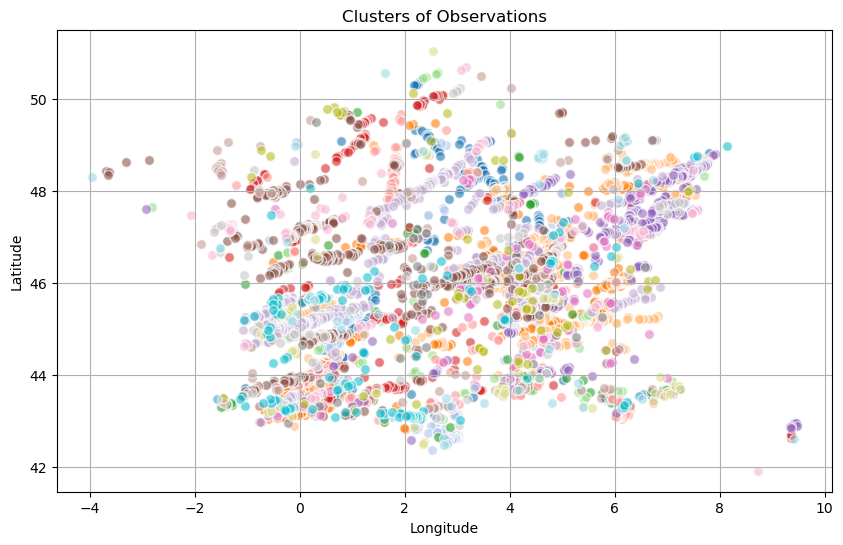

In [18]:
plt.figure(figsize=(10, 6))
unique_clusters = clustered_data['CLUSTER'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_clusters))

for i, cluster_label in enumerate(unique_clusters):
    cluster_points = clustered_data[clustered_data['CLUSTER'] == cluster_label]
    plt.scatter(cluster_points['LONGITUDE'], cluster_points['LATITUDE'], 
                color=colors(i), label=cluster_label, s=50, alpha=0.6, edgecolors='w')

plt.title('Clusters of Observations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.show()

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1499532532.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(centroids))


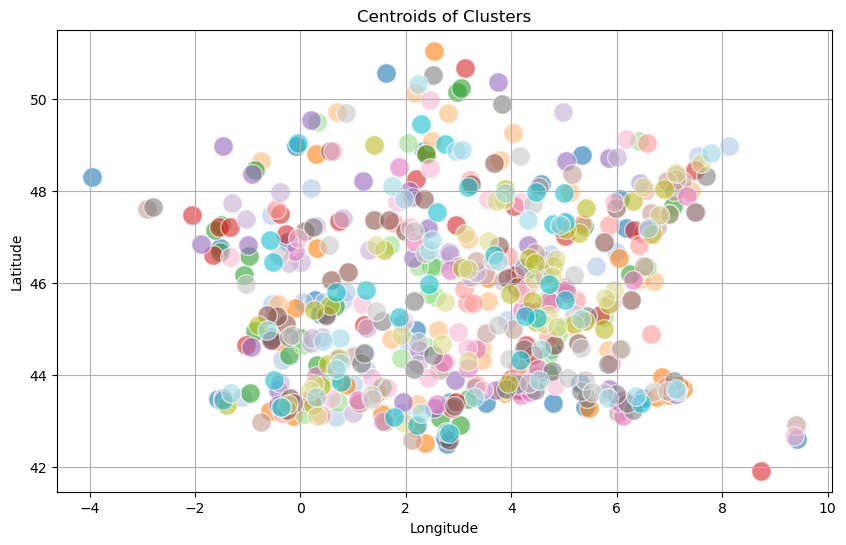

In [19]:
centroids = clustered_data.groupby('CLUSTER').agg({
    'LATITUDE': 'mean',
    'LONGITUDE': 'mean'
}).reset_index()

# Plotting the centroids using matplotlib
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab20', len(centroids))

for i, row in centroids.iterrows():
    plt.scatter(row['LONGITUDE'], row['LATITUDE'], 
                color=colors(i), label=row['CLUSTER'], s=200, alpha=0.6, edgecolors='w')

plt.title('Centroids of Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.show()


In [20]:
clustered_data.groupby('CLUSTER').size().mean(),clustered_data.groupby('CLUSTER').size().std()

(8.663176265270506, 13.732330860881675)

<Axes: >

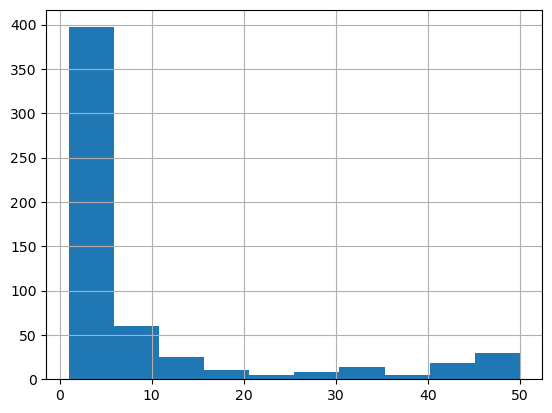

In [21]:
clustered_data.groupby('CLUSTER').size().hist()

## Introduction d'algorithmes d'apprentissage

In [22]:
clustered_data['TIME_EVENT'] = pd.to_datetime(clustered_data['TIME_EVENT'], format='%Y-%m-%d %H:%M:%S')

clustered_data['MONTH'] = clustered_data['TIME_EVENT'].dt.month
clustered_data['DAY'] = clustered_data['TIME_EVENT'].dt.day
clustered_data['HOUR'] = clustered_data['TIME_EVENT'].dt.hour

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [24]:
train_data = clustered_data[clustered_data['TIME_EVENT'].dt.year < 2024]
test_data = clustered_data[clustered_data['TIME_EVENT'].dt.year == 2024]

#On sépare les années pour créer un jeu de test

In [25]:
clustered_data['TIME_EVENT'] = pd.to_datetime(clustered_data['TIME_EVENT'])

clustered_data['YEAR'] = clustered_data['TIME_EVENT'].dt.year
clustered_data['MONTH'] = clustered_data['TIME_EVENT'].dt.month
clustered_data['DAY'] = clustered_data['TIME_EVENT'].dt.day
clustered_data['HOUR'] = clustered_data['TIME_EVENT'].dt.hour

clustered_data['CLUSTER_NUM'] = clustered_data['CLUSTER'].apply(lambda x: x.split('-C')[1])

# Création d'un identifiant unique pour le cluster
clustered_data['UNIQUE_CLUSTER_ID'] = clustered_data.apply(
    lambda row: f"{row['YEAR']}-{row['MONTH']}-{row['CLUSTER_NUM']}", axis=1
)

# Encodage de cet identifiant unique
label_encoder = LabelEncoder()
clustered_data['UNIQUE_CLUSTER_ID'] = label_encoder.fit_transform(clustered_data['UNIQUE_CLUSTER_ID'])

# Séparation des données d'entraînement (2018-2023) et de test (2024)
train_data = clustered_data[clustered_data['YEAR'] < 2024]
test_data = clustered_data[clustered_data['YEAR'] == 2024]

# Sélection des features
features = ['MONTH', 'DAY', 'HOUR', 'LATITUDE', 'LONGITUDE', 'UNIQUE_CLUSTER_ID']
X_train = train_data[features]
X_test = test_data[features]

y_train = [1] * len(X_train)
y_test = [1] * len(X_test)

In [26]:
print("Ensemble d'entraînement :")
print(X_train.head(), y_train[:5])
print("\nEnsemble de test :")
print(X_test.head(), y_test[:5])


Ensemble d'entraînement :
     MONTH  DAY  HOUR  LATITUDE  LONGITUDE  UNIQUE_CLUSTER_ID
308      9   17    17    43.893      0.863                181
309      9   17    17    43.884      0.823                181
310      9   17    17    43.873      0.842                181
311      9   17    17    43.875      0.823                181
312      9   17    17    43.865      0.832                181 [1, 1, 1, 1, 1]

Ensemble de test :
   MONTH  DAY  HOUR  LATITUDE  LONGITUDE  UNIQUE_CLUSTER_ID
0      5   20    15    47.350      5.117                193
1      5   20    15    47.317      5.017                193
3      5   20    14    47.100      4.667                193
2      5   20    15    47.250      6.667                196
4      5   20    14    47.133      6.533                196 [1, 1, 1, 1, 1]


In [27]:
features = ['MONTH', 'DAY', 'HOUR', 'UNIQUE_CLUSTER_ID']
X_train = train_data[features]
X_test = test_data[features]

In [28]:
y_train_latitude = train_data['LATITUDE']
y_train_longitude = train_data['LONGITUDE']
y_test_latitude = test_data['LATITUDE']
y_test_longitude = test_data['LONGITUDE']

In [29]:
# Modèle pour la latitude
model_latitude = LinearRegression()
model_latitude.fit(X_train, y_train_latitude)

# Modèle pour la longitude
model_longitude = LinearRegression()
model_longitude.fit(X_train, y_train_longitude)

LinearRegression()

In [30]:
y_pred_latitude = model_latitude.predict(X_test)
y_pred_longitude = model_longitude.predict(X_test)

In [31]:
mse_latitude = mean_squared_error(y_test_latitude, y_pred_latitude)
mae_latitude = mean_absolute_error(y_test_latitude, y_pred_latitude)

# Calcul des métriques d'évaluation pour la longitude
mse_longitude = mean_squared_error(y_test_longitude, y_pred_longitude)
mae_longitude = mean_absolute_error(y_test_longitude, y_pred_longitude)

# Affichage des résultats
print("Prédictions pour la latitude :", y_pred_latitude)
print("Latitude réelle              :", y_test_latitude.values)
print(f"Mean Squared Error Latitude: {mse_latitude}")
print(f"Mean Absolute Error Latitude: {mae_latitude}\n")

print("Prédictions pour la longitude :", y_pred_longitude)
print("Longitude réelle              :", y_test_longitude.values)
print(f"Mean Squared Error Longitude: {mse_longitude}")
print(f"Mean Absolute Error Longitude: {mae_longitude}")

Prédictions pour la latitude : [45.95847649 45.95847649 45.93300871 45.9535561  45.92808833 45.86147359
 45.89180958 46.04948446 46.04948446 46.04948446 46.04948446 46.04948446
 45.94761334 45.8917574  45.82514266 45.82514266 45.82514266 45.82514266
 45.82514266 45.82514266 45.82514266 45.82514266 45.82514266 45.82022228
 45.81858215 45.81858215 45.74217882 45.88094643 45.88094643 45.85547865
 45.82509049 45.82509049 45.82509049 45.82509049 45.79798258 45.77087468
 45.81914773 45.81914773 45.79367995 45.79367995 45.79367995 45.79367995
 45.79367995 45.76821217 45.76821217 45.74274439 45.71235623 45.70041853
 45.67003037 45.67003037 45.67003037 45.64456259 45.64456259 45.64292246
 45.64292246 45.64292246 45.61745469 45.61745469 45.61745469 45.59198691
 45.59198691 45.59198691 45.59198691 45.59198691 45.59198691 45.59198691
 45.59198691 45.59198691 45.59198691 45.59198691 45.59198691 45.59198691
 45.59198691 45.59198691 45.59198691 45.59198691 45.59198691 45.59198691
 45.59198691 45.5919

In [32]:
predicted_coordinates = list(zip(y_pred_latitude, y_pred_longitude))

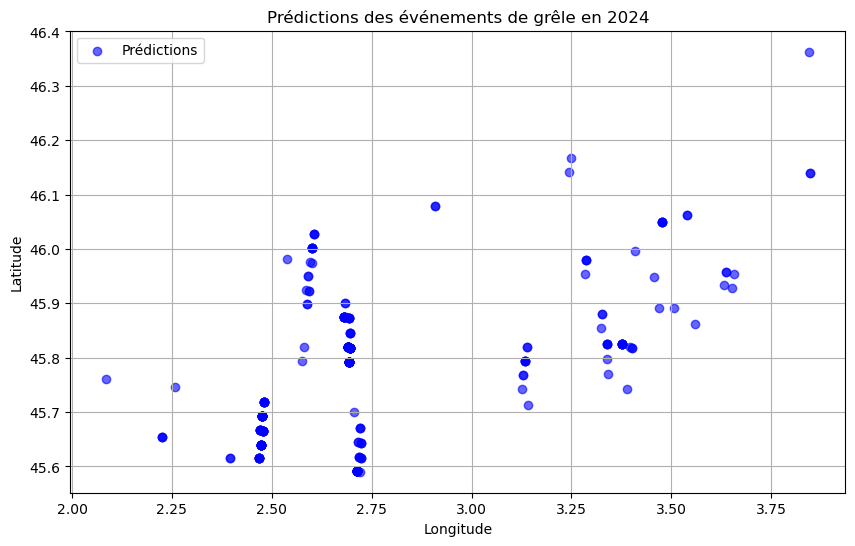

In [33]:
pred_latitudes, pred_longitudes = zip(*predicted_coordinates)

# Plot des prédictions
plt.figure(figsize=(10, 6))
plt.scatter(pred_longitudes, pred_latitudes, color='blue', label='Prédictions', alpha=0.6)

# Ajout de légendes et titres
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Prédictions des événements de grêle en 2024')
plt.legend()
plt.grid(True)
plt.show()

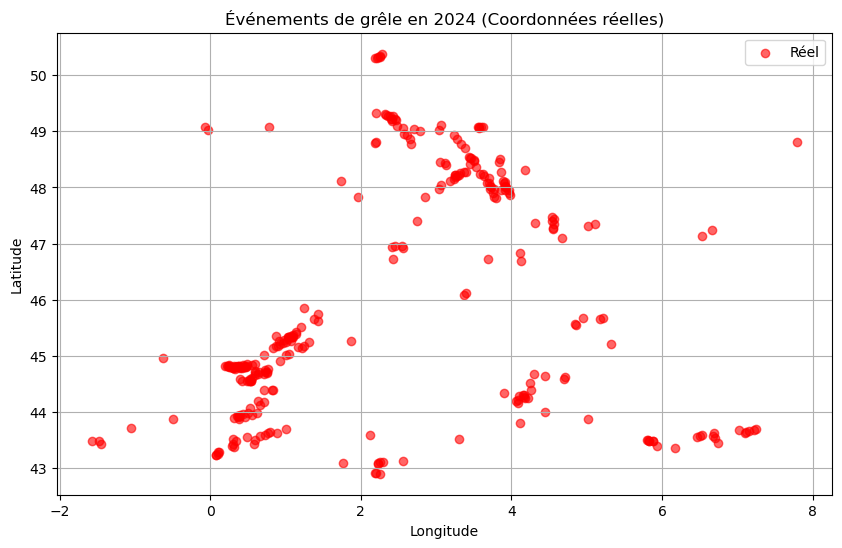

In [34]:
data_2024 = clustered_data[clustered_data['YEAR'] == 2024]

# Extraire les longitudes et latitudes pour 2024
real_longitudes = data_2024['LONGITUDE']
real_latitudes = data_2024['LATITUDE']

# Plot des coordonnées réelles
plt.figure(figsize=(10, 6))
plt.scatter(real_longitudes, real_latitudes, color='red', label='Réel', alpha=0.6)

# Ajout de légendes et titres
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Événements de grêle en 2024 (Coordonnées réelles)')
plt.legend()
plt.grid(True)
plt.show()


# Mauvaise approche et absence de variables explicatives.

On reprend en essayant de coupler avec une base de données météorologiques.

On va joindre nos deux bases sur le critère du département.

In [35]:
villes_df = pd.read_csv('villes_france.csv')

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1666018411.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  villes_df = pd.read_csv('villes_france.csv')


In [36]:
clustered_data = clustered_data.merge(villes_df, left_on='PLACE', right_on='Ozan', how='left')

In [37]:
print([repr(col) for col in villes_df.columns])

["'1'", "'01'", "'ozan'", "'OZAN'", "'ozan.1'", "'Ozan'", "'O250'", "'OSN'", "'01190'", "'284'", "'01284'", "'2'", "'26'", "'6'", "'618'", "'469'", "'500'", "'93'", "'6.6'", "'4.91667'", "'46.3833'", "'2866'", "'51546'", "'+45456'", "'462330'", "'170'", "'205'"]


In [38]:
clustered_data["01284"]

0       21657
1       21231
2       21087
3       25125
4       70136
        ...  
6018    83085
6019    66106
6020      NaN
6021    79299
6022    29016
Name: 01284, Length: 6023, dtype: object

In [39]:
clustered_data['CODE_DPT'] = clustered_data['01284'].astype(str).str[:2]
clustered_data['CODE_DPT'] = clustered_data['01284'].str[:2]

In [40]:
clustered_data['CODE_DPT'] = clustered_data['01284'].dropna().astype(str).str[:2]

In [41]:
clustered_data['CODE_DPT'].fillna('00', inplace=True)

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/842335860.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clustered_data['CODE_DPT'].fillna('00', inplace=True)


In [42]:
clustered_data['CODE_DPT']

0       21
1       21
2       21
3       25
4       70
        ..
6018    83
6019    66
6020    00
6021    79
6022    29
Name: CODE_DPT, Length: 6023, dtype: object

## Région Loire 

In [226]:
meteo42_2022=pd.read_csv('MENSQ_42_previous-1950-2022.csv', sep=';')
meteo42_2024=pd.read_csv('MENSQ_42_latest-2023-2024.csv', sep=';')

In [227]:
clustered_data[clustered_data['CODE_DPT'] == '42'].shape[0]
#Nombre d'observations dans la Loire

150

In [228]:
data_42=clustered_data[clustered_data['CODE_DPT']=='42']

In [243]:
data_42['TIME_EVENT']

135    2024-05-01 21:07:00
428    2023-09-12 17:35:00
504    2023-08-25 15:20:00
522    2023-08-25 14:55:00
553    2023-08-25 14:45:00
               ...        
5656   2019-07-06 12:45:00
5657   2019-07-06 08:30:00
5663   2019-07-01 17:30:00
5664   2019-07-01 17:00:00
5891   2018-07-03 17:00:00
Name: TIME_EVENT, Length: 150, dtype: datetime64[ns]

In [247]:
data_42['Annee']=data_42['TIME_EVENT'].dt.year
data_42['Mois']=data_42['TIME_EVENT'].dt.month

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/393443700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_42['Annee']=data_42['TIME_EVENT'].dt.year
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/393443700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_42['Mois']=data_42['TIME_EVENT'].dt.month


In [253]:
# Créer une nouvelle colonne 'YYYY-MM' avec des objets datetime
data_42['YYYY-MM'] = pd.to_datetime(data_42['Annee'].astype(str) + '-' + data_42['Mois'].astype(str).str.zfill(2), format='%Y-%m')

# Convertir la colonne datetime en format string 'YYYY-MM'
data_42['YYYY-MM'] = data_42['YYYY-MM'].dt.strftime('%Y-%m')

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/518907721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_42['YYYY-MM'] = pd.to_datetime(data_42['Annee'].astype(str) + '-' + data_42['Mois'].astype(str).str.zfill(2), format='%Y-%m')
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/518907721.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_42['YYYY-MM'] = data_42['YYYY-MM'].dt.strftime('%Y-%m')


In [275]:
meteo42_2022['AAAAMM'] = meteo42_2022['AAAAMM'].astype(str)

# Extraire l'année et convertir en entier
meteo42_2022['Annee'] = meteo42_2022['AAAAMM'].str[:4].astype(int)
meteo42_2022['Mois'] = meteo42_2022['AAAAMM'].str[-2:].astype(int)
# Filtrer les données pour ne garder que celles de 2018 à 2022
meteo_42_18_22 = meteo42_2022[(meteo42_2022['Annee'] >= 2018) & (meteo42_2022['Annee'] <= 2022)]
meteo_42_23_24 = meteo42_2024


In [301]:
meteo_42_23_24['AAAAMM'] = meteo_42_23_24['AAAAMM'].astype(str)

# Extraire l'année et convertir en entier
meteo_42_23_24['Annee'] = meteo_42_23_24['AAAAMM'].str[:4].astype(int)
meteo_42_23_24['Mois'] = meteo_42_23_24['AAAAMM'].str[-2:].astype(int)

In [269]:
meteo_42_18_22['YYYY-MM'] = meteo_42_18_22['Annee'].astype(str) + '-' + meteo_42_18_22['Mois'].astype(str).str.zfill(2)

# Convertir la colonne 'YYYY-MM' en objet datetime
meteo_42_18_22['YYYY-MM'] = pd.to_datetime(meteo_42_18_22['YYYY-MM'], format='%Y-%m')

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/966967876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_42_18_22['YYYY-MM'] = meteo_42_18_22['Annee'].astype(str) + '-' + meteo_42_18_22['Mois'].astype(str).str.zfill(2)
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/966967876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_42_18_22['YYYY-MM'] = pd.to_datetime(meteo_42_18_22['YYYY-MM'], format='%Y-%m')


In [286]:
# Créer une nouvelle colonne 'YYYY-MM' avec des objets datetime
meteo_42_18_22['YYYY-MM'] = pd.to_datetime(meteo_42_18_22['Annee'].astype(str) + '-' + meteo_42_18_22['Mois'].astype(str).str.zfill(2), format='%Y-%m')

# Convertir la colonne datetime en format string 'YYYY-MM'
meteo_42_18_22['YYYY-MM'] = meteo_42_18_22['YYYY-MM'].dt.strftime('%Y-%m')


/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/2659600104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_42_18_22['YYYY-MM'] = pd.to_datetime(meteo_42_18_22['Annee'].astype(str) + '-' + meteo_42_18_22['Mois'].astype(str).str.zfill(2), format='%Y-%m')
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/2659600104.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_42_18_22['YYYY-MM'] = meteo_42_18_22['YYYY-MM'].dt.strftime('%Y-%m')


On a mis au même format les dates des évènements et ceux des données météo.

In [302]:
# Créer une nouvelle colonne 'YYYY-MM' avec des objets datetime
meteo_42_23_24['YYYY-MM'] = pd.to_datetime(meteo_42_23_24['Annee'].astype(str) + '-' + meteo_42_23_24['Mois'].astype(str).str.zfill(2), format='%Y-%m')

# Convertir la colonne datetime en format string 'YYYY-MM'
meteo_42_23_24['YYYY-MM'] = meteo_42_23_24['YYYY-MM'].dt.strftime('%Y-%m')

In [289]:
data_42_24=data_42[data_42['Annee']>2022]
data_42_22=data_42[data_42['Annee']<=2022]
#Séparation de la BDD initiale

In [296]:
bdd_18_22 = pd.merge(data_42_22, meteo_42_18_22, on='YYYY-MM',how='inner')

In [305]:
bdd_23_24 = pd.merge(data_42_24, meteo_42_23_24, on='YYYY-MM',how='inner')

In [307]:
bdd_23_24_sd = bdd_23_24.drop_duplicates(subset='ID')

In [309]:
bdd_18_22_sd = bdd_18_22.drop_duplicates(subset='ID')

In [364]:
# Convertir la colonne 'DateTime' en datetime
bdd_18_22_sd['DATE2'] = pd.to_datetime(bdd_18_22_sd['TIME_EVENT'])
bdd_18_22_sd['DATE1'] = pd.to_datetime(bdd_18_22_sd['TIME_EVENT'])
bdd_18_22_sd['DATE1'] = bdd_18_22_sd['DATE1'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=x.day))
# Extraire YYYY-MM et créer un nouveau datetime avec le jour fixé au premier du mois
bdd_18_22_sd['DATE2'] = bdd_18_22_sd['DATE2'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=1))


/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1630678508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_18_22_sd['DATE2'] = pd.to_datetime(bdd_18_22_sd['TIME_EVENT'])
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1630678508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_18_22_sd['DATE1'] = pd.to_datetime(bdd_18_22_sd['TIME_EVENT'])
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1630678508.py:4: SettingWithCopyWarning: 
A value is tryi

In [482]:
bdd_23_24_sd['DATE1'] = pd.to_datetime(bdd_23_24_sd['TIME_EVENT'])
bdd_23_24_sd['DATE1'] = bdd_23_24_sd['DATE1'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=x.day))
bdd_23_24_sd['DATE1'].astype(str)

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/2912867351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_23_24_sd['DATE1'] = pd.to_datetime(bdd_23_24_sd['TIME_EVENT'])
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/2912867351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_23_24_sd['DATE1'] = bdd_23_24_sd['DATE1'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=x.day))


0       2024-05-01
28      2023-09-12
56      2023-08-25
84      2023-08-25
112     2023-08-25
           ...    
1708    2023-04-28
1736    2023-04-28
1764    2023-04-28
1792    2023-04-28
1820    2023-04-28
Name: DATE1, Length: 66, dtype: object

### Enfin ! On a réussi à :
- Récupérer, dans la Loire, entre 2018 et 2022 puis 2023 et 2024 toutes les observations de grêle de l'ESSL.
- Puis à les coupler avec des données météorologiques pour avoir des variables explicatives.

Désormais, on peut créer une ultime BDD pour chacune des deux périodes, avec un 1 s'il y a eu un évenement de grêle et un 0 sinon, puis d'effectuer notre RL dessus.

Les co-variables retenues seront :
- NBJTX30
- NBJORAG
- FXIAB

In [352]:
dates_range = pd.date_range(start='2018-01-01', end='2022-12-31', freq='D')

# Convertir cette série en DataFrame
bdd_finale_18_22 = pd.DataFrame(dates_range, columns=['Date'])

# Ajouter une colonne d'occurence initialisée à 0
bdd_finale_18_22['Occurence'] = 0
#bdd_finale_18_22['Date2']=bdd_18_22_sd['DATE2']
#bdd_finale_18_22['NBJTX30']=bdd_18_22_sd['NBJTX30']
#bdd_finale_18_22['NBJORAG']=bdd_18_22_sd['NBJORAG']
#bdd_finale_18_22['FXIAB']=bdd_18_22_sd['FXIAB']
# 2. Extraire les dates de 'TIME_EVENT' et les convertir en format datetime
bdd_18_22['TIME_EVENT'] = pd.to_datetime(bdd_18_22['TIME_EVENT'])
dates_presente = bdd_18_22['TIME_EVENT'].dt.date

# 3. Marquer les dates présentes avec 1
bdd_finale_18_22['Occurence'] = bdd_finale_18_22['Date'].dt.date.isin(dates_presente).astype(int)


In [357]:
bdd_FIN = bdd_18_22_sd[['TIME_EVENT','DATE2','NBJTX30','FXIAB','NBJORAG']]

In [372]:
bdd_FIN.rename(columns={'DATE2': 'Date'}, inplace=True)

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1101835536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_FIN.rename(columns={'DATE2': 'Date'}, inplace=True)


In [373]:
FIN_bdd_22_24 = pd.merge(bdd_finale_18_22, bdd_FIN, on='Date',how='outer')

In [381]:
# Convertir les colonnes 'Date' et 'TIME_EVENT' en format datetime
bdd_finale_18_22['Date'] = pd.to_datetime(bdd_finale_18_22['Date'])
bdd_FIN['Date'] = pd.to_datetime(bdd_FIN['Date'])
bdd_FIN['TIME_EVENT'] = pd.to_datetime(bdd_FIN['TIME_EVENT'], errors='coerce')

# Merge des DataFrames
merged_df = pd.merge(bdd_finale_18_22, bdd_FIN, on='Date', how='outer')

# Remplacer les dates de TIME_EVENT par les dates de la colonne 'Date' si nécessaire
merged_df['TIME_EVENT'] = merged_df.apply(
    lambda row: row['Date'] if pd.isna(row['TIME_EVENT']) else row['TIME_EVENT'].replace(hour=0, minute=0, second=0, microsecond=0), axis=1
)

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/3404874040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_FIN['Date'] = pd.to_datetime(bdd_FIN['Date'])
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/3404874040.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_FIN['TIME_EVENT'] = pd.to_datetime(bdd_FIN['TIME_EVENT'], errors='coerce')


In [402]:
final_df = merged_df.drop_duplicates(subset=['Date', 'TIME_EVENT'])

In [460]:
final_df2=final_df[(final_df['Date']>='2018-07-01')]
final_df2=final_df2[(final_df2['Date']<='2022-08-31')]

In [461]:
final_df2

,Date,Occurence,TIME_EVENT,NBJTX30,FXIAB,NBJORAG
181,2018-07-01,0,2018-07-03,14.0,21.7,9.0
182,2018-07-02,0,2018-07-02,NaN,NaN,NaN
183,2018-07-03,1,2018-07-03,NaN,NaN,NaN
184,2018-07-04,0,2018-07-04,NaN,NaN,NaN
185,2018-07-05,0,2018-07-05,NaN,NaN,NaN
...,...,...,...,...,...,...
1709,2022-08-27,0,2022-08-27,NaN,NaN,NaN
1710,2022-08-28,0,2022-08-28,NaN,NaN,NaN
1711,2022-08-29,0,2022-08-29,NaN,NaN,NaN
1712,2022-08-30,1,2022-08-30,NaN,NaN,NaN


In [462]:
final_df2['Month'] = final_df2['Date'].dt.to_period('M')

# Identifier les lignes du premier jour de chaque mois
first_day_of_month = final_df2[final_df2['Date'].dt.is_month_start]

# Sélectionner uniquement les colonnes pertinentes et le mois
first_day_of_month = first_day_of_month[['Month', 'NBJTX30', 'NBJORAG', 'FXIAB']]

# Fusionner pour propager les valeurs du premier jour de chaque mois à tous les jours du mois
final_df2 = pd.merge(final_df2, first_day_of_month, on='Month', how='left', suffixes=('', '_first'))

# Remplir les NaN dans les colonnes originales avec les valeurs du premier jour du mois
final_df2['NBJTX30'] = final_df2['NBJTX30'].fillna(final_df2['NBJTX30_first'])
final_df2['NBJORAG'] = final_df2['NBJORAG'].fillna(final_df2['NBJORAG_first'])
final_df2['FXIAB'] = final_df2['FXIAB'].fillna(final_df2['FXIAB_first'])

# Supprimer les colonnes temporaires utilisées pour le remplissage
final_df2 = final_df2.drop(columns=['Month', 'NBJTX30_first', 'NBJORAG_first', 'FXIAB_first'])

In [464]:
final_df2=final_df2.drop(columns='TIME_EVENT')

In [465]:
final_df2

,Date,Occurence,NBJTX30,FXIAB,NBJORAG
0,2018-07-01,0,14.0,21.7,9.0
1,2018-07-02,0,14.0,21.7,9.0
2,2018-07-03,1,14.0,21.7,9.0
3,2018-07-04,0,14.0,21.7,9.0
4,2018-07-05,0,14.0,21.7,9.0
...,...,...,...,...,...
1883,2022-08-29,0,15.0,17.2,5.0
1884,2022-08-30,1,15.0,17.2,5.0
1885,2022-08-30,1,15.0,17.2,5.0
1886,2022-08-31,0,15.0,17.2,5.0


In [471]:
final_df_2018_2022 = final_df2.drop_duplicates(subset='Date')

In [472]:
final_df_2018_2022

,Date,Occurence,NBJTX30,FXIAB,NBJORAG
0,2018-07-01,0,14.0,21.7,9.0
1,2018-07-02,0,14.0,21.7,9.0
2,2018-07-03,1,14.0,21.7,9.0
3,2018-07-04,0,14.0,21.7,9.0
4,2018-07-05,0,14.0,21.7,9.0
...,...,...,...,...,...
1878,2022-08-27,0,15.0,17.2,5.0
1880,2022-08-28,0,15.0,17.2,5.0
1882,2022-08-29,0,15.0,17.2,5.0
1884,2022-08-30,1,15.0,17.2,5.0


In [496]:
dates_range2 = pd.date_range(start='2023-01-01', end='2024-06-30', freq='D')

In [497]:
bdd_23_24_sd=bdd_23_24_sd.drop_duplicates('DATE1')

In [498]:
bdd_finale_23_24 = pd.DataFrame(dates_range2, columns=['Date'])

In [499]:
bdd_finale_23_24['Occurence'] = 0

In [500]:
bdd_23_24_sd['TIME_EVENT'] = pd.to_datetime(bdd_23_24_sd['TIME_EVENT'])
dates_presente = bdd_23_24_sd['TIME_EVENT'].dt.date

In [501]:
bdd_finale_23_24['Occurence'] = bdd_finale_23_24['Date'].dt.date.isin(dates_presente).astype(int)

In [506]:
bdd_FIN2 = bdd_23_24_sd[['TIME_EVENT','DATE1','NBJTX30','FXIAB','NBJORAG']]

In [510]:
bdd_FIN2.rename(columns={'DATE1': 'Date'}, inplace=True)

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1466764321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_FIN2.rename(columns={'DATE1': 'Date'}, inplace=True)


In [511]:
FIN_bdd_23_24 = pd.merge(bdd_finale_23_24, bdd_FIN2, on='Date',how='outer')

In [512]:
# Convertir les colonnes 'Date' et 'TIME_EVENT' en format datetime
bdd_finale_23_24['Date'] = pd.to_datetime(bdd_finale_23_24['Date'])
bdd_FIN2['Date'] = pd.to_datetime(bdd_FIN2['Date'])
bdd_FIN2['TIME_EVENT'] = pd.to_datetime(bdd_FIN2['TIME_EVENT'], errors='coerce')

# Merge des DataFrames
merged_df2 = pd.merge(bdd_finale_23_24, bdd_FIN2, on='Date', how='outer')

# Remplacer les dates de TIME_EVENT par les dates de la colonne 'Date' si nécessaire
merged_df2['TIME_EVENT'] = merged_df2.apply(
    lambda row: row['Date'] if pd.isna(row['TIME_EVENT']) else row['TIME_EVENT'].replace(hour=0, minute=0, second=0, microsecond=0), axis=1
)

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/2725745967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_FIN2['Date'] = pd.to_datetime(bdd_FIN2['Date'])
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/2725745967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdd_FIN2['TIME_EVENT'] = pd.to_datetime(bdd_FIN2['TIME_EVENT'], errors='coerce')


In [531]:
bddtemps2324=pd.DataFrame(dates_range2, columns=['Date'])

In [533]:
bddtemps2324['Month']=bddtemps2324['Date'].dt.month

In [535]:
METO42_=meteo42_2024[['AAAAMM','NBJTX30','FXIAB','NBJORAG']]

In [539]:
METO42_=METO42_.head(19)

In [541]:
METO42_['date'] = pd.to_datetime(METO42_['AAAAMM'], format='%Y%m')

# Extraire le mois et l'année
METO42_['mois'] = METO42_['date'].dt.month
METO42_['année'] = METO42_['date'].dt.year

/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1447665028.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  METO42_['date'] = pd.to_datetime(METO42_['AAAAMM'], format='%Y%m')
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1447665028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  METO42_['mois'] = METO42_['date'].dt.month
/var/folders/yn/y92zhq8j1fg6pn18_cj_mr9m0000gn/T/ipykernel_93382/1447665028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [544]:
METO42_=METO42_.drop(columns=['AAAAMM'])

In [546]:
bddtemps2324

,Date,Month
0,2023-01-01,1
1,2023-01-02,1
2,2023-01-03,1
3,2023-01-04,1
4,2023-01-05,1
...,...,...
542,2024-06-26,6
543,2024-06-27,6
544,2024-06-28,6
545,2024-06-29,6


In [558]:
METo42_=pd.DataFrame(METO42_)

In [589]:
METo42_=METo42_.rename(columns={'date' : 'Date'})

In [590]:
bddtemps2324.columns

Index(['Date', 'Month'], dtype='object')

In [591]:
METo42_.columns

Index(['NBJTX30', 'FXIAB', 'NBJORAG', 'Date', 'mois', 'année'], dtype='object')

In [592]:
bddtemps_23_24=pd.merge(left=bddtemps2324, right=METo42_, on='Date',how='outer')

In [580]:
merged_df2

,Date,Occurence,TIME_EVENT,NBJTX30,FXIAB,NBJORAG
0,2023-01-01,0,2023-01-01,NaN,NaN,NaN
1,2023-01-02,0,2023-01-02,NaN,NaN,NaN
2,2023-01-03,0,2023-01-03,NaN,NaN,NaN
3,2023-01-04,0,2023-01-04,NaN,NaN,NaN
4,2023-01-05,0,2023-01-05,NaN,NaN,NaN
...,...,...,...,...,...,...
542,2024-06-26,0,2024-06-26,NaN,NaN,NaN
543,2024-06-27,0,2024-06-27,NaN,NaN,NaN
544,2024-06-28,0,2024-06-28,NaN,NaN,NaN
545,2024-06-29,0,2024-06-29,NaN,NaN,NaN


In [599]:
merged_df23=merged_df2.drop(columns=['NBJTX30','FXIAB','NBJORAG'])

In [593]:
bddtemps_23_24

,Date,Month,NBJTX30,FXIAB,NBJORAG,mois,année
0,2023-01-01,1.0,0.0,19.5,0.0,1.0,2023.0
1,2023-01-02,1.0,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,1.0,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,1.0,NaN,NaN,NaN,NaN,NaN
4,2023-01-05,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
543,2024-06-27,6.0,NaN,NaN,NaN,NaN,NaN
544,2024-06-28,6.0,NaN,NaN,NaN,NaN,NaN
545,2024-06-29,6.0,NaN,NaN,NaN,NaN,NaN
546,2024-06-30,6.0,NaN,NaN,NaN,NaN,NaN


In [594]:
bddtemps_23_24['Month'] = bddtemps_23_24['Date'].dt.to_period('M')

# Identifier les lignes du premier jour de chaque mois
first_day_of_month = bddtemps_23_24[bddtemps_23_24['Date'].dt.is_month_start]

# Sélectionner uniquement les colonnes pertinentes et le mois
first_day_of_month = first_day_of_month[['Month', 'NBJTX30', 'NBJORAG', 'FXIAB']]

# Fusionner pour propager les valeurs du premier jour de chaque mois à tous les jours du mois
bddtemps_23_24 = pd.merge(bddtemps_23_24, first_day_of_month, on='Month', how='left', suffixes=('', '_first'))

# Remplir les NaN dans les colonnes originales avec les valeurs du premier jour du mois
bddtemps_23_24['NBJTX30'] = bddtemps_23_24['NBJTX30'].fillna(bddtemps_23_24['NBJTX30_first'])
bddtemps_23_24['NBJORAG'] = bddtemps_23_24['NBJORAG'].fillna(bddtemps_23_24['NBJORAG_first'])
bddtemps_23_24['FXIAB'] = bddtemps_23_24['FXIAB'].fillna(bddtemps_23_24['FXIAB_first'])

# Supprimer les colonnes temporaires utilisées pour le remplissage
bddtemps_23_24 = bddtemps_23_24.drop(columns=['Month', 'NBJTX30_first', 'NBJORAG_first', 'FXIAB_first'])

In [597]:
bddtemps_23_24

,Date,NBJTX30,FXIAB,NBJORAG,mois,année
0,2023-01-01,0.0,19.5,0.0,1.0,2023.0
1,2023-01-02,0.0,19.5,0.0,NaN,NaN
2,2023-01-03,0.0,19.5,0.0,NaN,NaN
3,2023-01-04,0.0,19.5,0.0,NaN,NaN
4,2023-01-05,0.0,19.5,0.0,NaN,NaN
...,...,...,...,...,...,...
543,2024-06-27,3.0,18.0,7.0,NaN,NaN
544,2024-06-28,3.0,18.0,7.0,NaN,NaN
545,2024-06-29,3.0,18.0,7.0,NaN,NaN
546,2024-06-30,3.0,18.0,7.0,NaN,NaN


In [611]:
final_df_2023_2024=pd.merge(left=merged_df23,right=bddtemps_23_24, on='Date', how='outer')

In [612]:
final_df_2023_2024=final_df_2023_2024.drop(547)

In [616]:
final_df_2023_2024['Occurence']=final_df_2023_2024['Occurence'].astype(int)

In [622]:
final_df_2023_2024=final_df_2023_2024.drop(columns=['TIME_EVENT'])

In [624]:
final_df_2018_2022

,Date,Occurence,NBJTX30,FXIAB,NBJORAG
0,2018-07-01,0,14.0,21.7,9.0
1,2018-07-02,0,14.0,21.7,9.0
2,2018-07-03,1,14.0,21.7,9.0
3,2018-07-04,0,14.0,21.7,9.0
4,2018-07-05,0,14.0,21.7,9.0
...,...,...,...,...,...
1878,2022-08-27,0,15.0,17.2,5.0
1880,2022-08-28,0,15.0,17.2,5.0
1882,2022-08-29,0,15.0,17.2,5.0
1884,2022-08-30,1,15.0,17.2,5.0


In [623]:
final_df_2023_2024

,Date,Occurence,NBJTX30,FXIAB,NBJORAG
0,2023-01-01,0,0.0,19.5,0.0
1,2023-01-02,0,0.0,19.5,0.0
2,2023-01-03,0,0.0,19.5,0.0
3,2023-01-04,0,0.0,19.5,0.0
4,2023-01-05,0,0.0,19.5,0.0
...,...,...,...,...,...
542,2024-06-26,0,3.0,18.0,7.0
543,2024-06-27,0,3.0,18.0,7.0
544,2024-06-28,0,3.0,18.0,7.0
545,2024-06-29,0,3.0,18.0,7.0


# On y est !

Avec final_df_2018_2022 et final_df_2023_2024, on a des bases de données propres, qui contiennent des 0 aux lignes où il n'y a pas eu d'événements de grêle et des 1 sinon, ainsi que des données météo qui correspondent à ces mois (co-variables).

# Machine Learning

On peut désormais commencer à appliquer nos algorithmes afin d'apprentissage.

### On va devoir affinier l'échelle ; sinon, on ne trouve aucun 1.

In [649]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

/opt/anaconda3/envs/monenv/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Accuracy: 0.9250457038391224
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       530
           1       0.10      0.18      0.13        17

    accuracy                           0.93       547
   macro avg       0.54      0.56      0.54       547
weighted avg       0.95      0.93      0.93       547



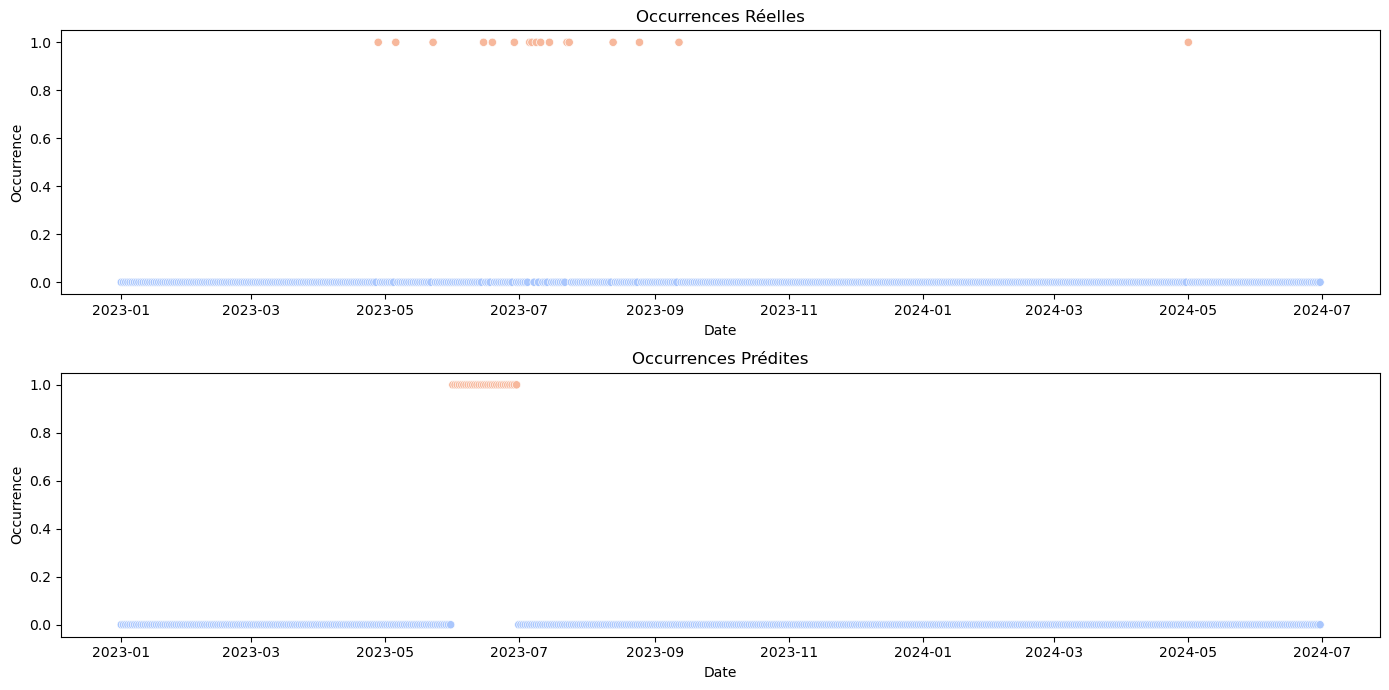

In [644]:
X_train = final_df_2018_2022[features]
y_train = final_df_2018_2022[target]

X_test = final_df_2023_2024[features]
y_test = final_df_2023_2024[target]

# Entraîner un modèle de HistGradientBoostingClassifier avec pondération des classes
model = HistGradientBoostingClassifier(random_state=42, class_weight={0: 1, 1: 10})
model.fit(X_train, y_train)

# Prédire sur le jeu de test
y_pred = model.predict(X_test)

# Ajouter les prédictions au dataframe de test
final_df_2023_2024['Predicted_Occurrence'] = y_pred

# Évaluer les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Convertir la colonne Date en type datetime
final_df_2023_2024['Date'] = pd.to_datetime(final_df_2023_2024['Date'])

# Définir la taille de la figure
plt.figure(figsize=(14, 7))

# Tracer les occurrences réelles
plt.subplot(2, 1, 1)
sns.scatterplot(x='Date', y='Occurence', data=final_df_2023_2024, hue='Occurence', palette='coolwarm', legend=False)
plt.title('Occurrences Réelles')
plt.xlabel('Date')
plt.ylabel('Occurrence')

# Tracer les occurrences prédites
plt.subplot(2, 1, 2)
sns.scatterplot(x='Date', y='Predicted_Occurrence', data=final_df_2023_2024, hue='Predicted_Occurrence', palette='coolwarm', legend=False)
plt.title('Occurrences Prédites')
plt.xlabel('Date')
plt.ylabel('Occurrence')

# Ajuster la mise en page
plt.tight_layout()
plt.show()

Accuracy: 0.9341864716636198
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       530
           1       0.00      0.00      0.00        17

    accuracy                           0.93       547
   macro avg       0.48      0.48      0.48       547
weighted avg       0.94      0.93      0.94       547

Confusion Matrix:
 [[511  19]
 [ 17   0]]


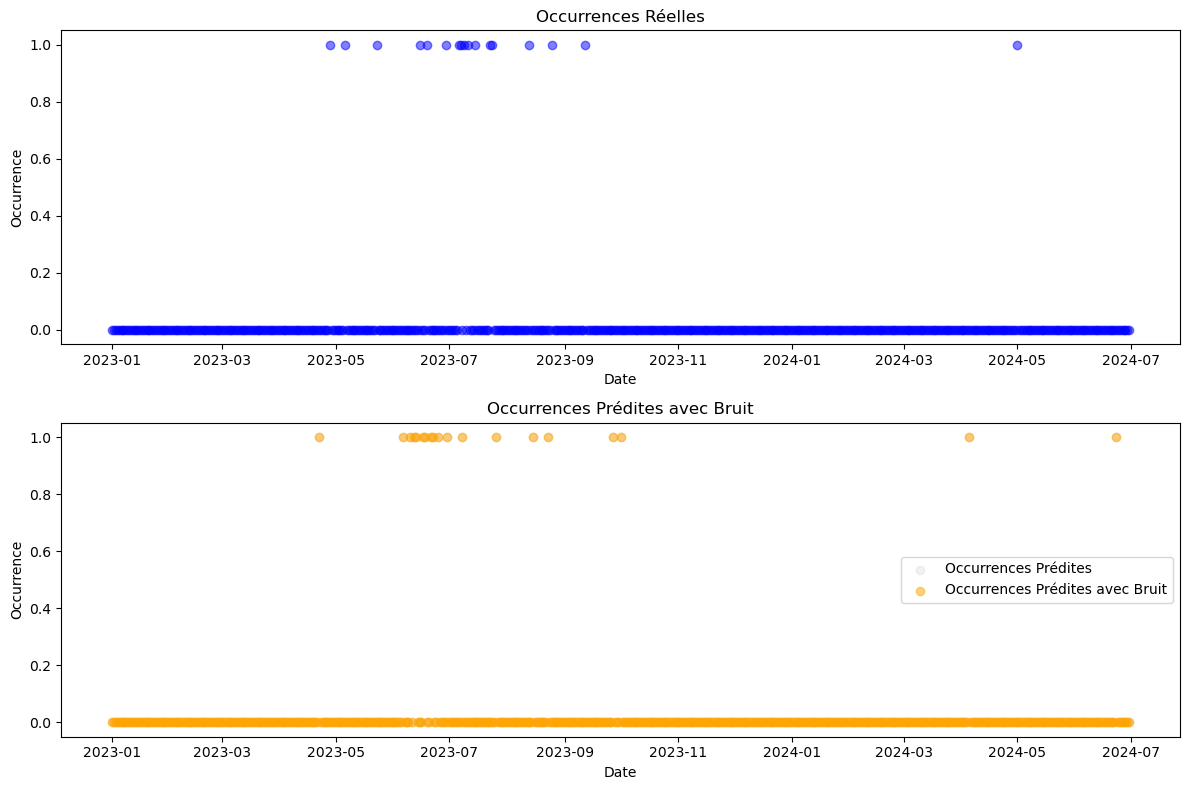

In [711]:
X_train = final_df_2018_2022[['NBJTX30', 'FXIAB', 'NBJORAG']]
y_train = final_df_2018_2022['Occurence']

X_test = final_df_2023_2024[['NBJTX30', 'FXIAB', 'NBJORAG']]
y_test = final_df_2023_2024['Occurence']

# Création et entraînement du modèle HistGradientBoostingClassifier
model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Prédiction des probabilités sur le jeu de test
y_prob = model.predict_proba(X_test)[:, 1]

# Ajout de bruit gaussien aux probabilités
noise_std_dev = 0.128 # Écart-type du bruit
noisy_prob = y_prob + np.random.normal(0, noise_std_dev, y_prob.shape)

# S'assurer que les probabilités restent dans l'intervalle [0, 1]
noisy_prob = np.clip(noisy_prob, 0, 1)

# Décision de la classe en fonction des probabilités bruitées
threshold = 0.32
y_pred_noisy = (noisy_prob > threshold).astype(int)

# Évaluation du modèle avec les prédictions bruitées
accuracy = accuracy_score(y_test, y_pred_noisy)
report = classification_report(y_test, y_pred_noisy)
conf_matrix = confusion_matrix(y_test, y_pred_noisy)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

# Ajout de bruit aux positions des points prédits pour les éparpiller uniquement pour la classe 1
y_pred_noisy_scatter = y_pred_noisy.astype(float)  # Conversion en float
#y_pred_noisy_scatter[y_pred_noisy_scatter == 1] += np.random.normal(0, 0.05, y_pred_noisy_scatter[y_pred_noisy_scatter == 1].shape)

# Visualisation des résultats
plt.figure(figsize=(12, 8))

# Scatter plot des occurrences réelles
plt.subplot(2, 1, 1)
plt.scatter(final_df_2023_2024['Date'], y_test, alpha=0.5, label='Occurrences Réelles', color='blue')
plt.title('Occurrences Réelles')
plt.xlabel('Date')
plt.ylabel('Occurrence')

# Scatter plot des occurrences prédites avec bruit
plt.subplot(2, 1, 2)
plt.scatter(final_df_2023_2024['Date'], y_pred_noisy, alpha=0.3, label='Occurrences Prédites', color='lightgray')
plt.scatter(final_df_2023_2024['Date'], y_pred_noisy_scatter, alpha=0.5, label='Occurrences Prédites avec Bruit', color='orange')
plt.title('Occurrences Prédites avec Bruit')
plt.xlabel('Date')
plt.ylabel('Occurrence')

plt.tight_layout()
plt.legend()
plt.show()